# Import

In [1615]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norm
from statsmodels.tsa.holtwinters import Holt

# Read Data

Here we import our dataset from https://data.humdata.org/dataset/wfp-food-prices-for-india?

In [1616]:
df = pd.read_csv("./food_prices_india.csv", low_memory=False)

In [1617]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139658 entries, 0 to 139657
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   date       139658 non-null  object
 1   admin1     139145 non-null  object
 2   admin2     139145 non-null  object
 3   market     139658 non-null  object
 4   latitude   139145 non-null  object
 5   longitude  139145 non-null  object
 6   category   139658 non-null  object
 7   commodity  139658 non-null  object
 8   unit       139658 non-null  object
 9   priceflag  139658 non-null  object
 10  pricetype  139658 non-null  object
 11  currency   139658 non-null  object
 12  price      139658 non-null  object
 13  usdprice   139658 non-null  object
dtypes: object(14)
memory usage: 14.9+ MB


In [1618]:
df.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,1994-01-15,Delhi,Delhi,Delhi,28.666667,77.216667,cereals and tubers,Wheat,KG,actual,Retail,INR,5.0,0.1594
2,1994-01-15,Delhi,Delhi,Delhi,28.666667,77.216667,miscellaneous food,Sugar,KG,actual,Retail,INR,13.5,0.4303
3,1994-01-15,Gujarat,Ahmadabad,Ahmedabad,23.033333,72.616667,cereals and tubers,Rice,KG,actual,Retail,INR,6.8,0.2167
4,1994-01-15,Gujarat,Ahmadabad,Ahmedabad,23.033333,72.616667,cereals and tubers,Wheat,KG,actual,Retail,INR,6.2,0.1976


# Data Cleaning

We will remove the first row because it includes an example descriptive sample that specifies the value of each column. We will also remove unnecessary columns.

In [1619]:
# remove first descriptive row
df_cleaned = df.drop(index=0)

# remove unused columns
df_cleaned = df_cleaned.drop(columns=["admin1", "admin2", "latitude", "longitude", "priceflag", "pricetype", "currency", "price"])

# convert 'date' to datetime type
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])

# convert 'price' and 'usdprice' to numeric (float) and handle any errors
df_cleaned['usdprice'] = pd.to_numeric(df_cleaned['usdprice'], errors='coerce')

In [1620]:
# convert prices to per KG terms
def convert_to_per_kg(row):
    if row['unit'] == 'KG':
        return row['usdprice']
    elif row['unit'] == '100 KG':
        return row['usdprice'] / 100
    elif row['unit'] == 'L':
        return row['usdprice']
    else:
        raise ValueError("Unknown unit")

In [1621]:
# Apply the function to each row in the DataFrame
df_cleaned['usdprice'] = df_cleaned.apply(convert_to_per_kg, axis=1)

In [1622]:
df_cleaned[df_cleaned["unit"] == "100 KG"]

,date,market,category,commodity,unit,usdprice
1711,2000-01-15,Patna,cereals and tubers,Rice,100 KG,0.183644
1717,2000-01-15,Delhi,cereals and tubers,Rice,100 KG,0.246771
1731,2000-01-15,Mumbai,cereals and tubers,Rice,100 KG,0.260889
1732,2000-01-15,Mumbai,cereals and tubers,Wheat,100 KG,0.208590
1741,2000-01-15,Chennai,cereals and tubers,Rice,100 KG,0.245050
...,...,...,...,...,...,...
71780,2020-10-15,Delhi,cereals and tubers,Rice,100 KG,0.390480
71781,2020-10-15,Delhi,cereals and tubers,Wheat,100 KG,0.246826
72196,2020-10-15,Mumbai,cereals and tubers,Rice,100 KG,0.327439
72197,2020-10-15,Mumbai,cereals and tubers,Wheat,100 KG,0.378601


# Data Analysis

In [1623]:
# descriptive statistics for numerical columns
print("Descriptive Statistics:")
df_cleaned.describe()

Descriptive Statistics:


,date,usdprice
count,139657,139657.000000
mean,2018-07-23 13:15:10.330309120,1.024265
min,1994-01-15 00:00:00,0.059600
25%,2016-03-15 00:00:00,0.389600
50%,2020-07-15 00:00:00,0.693400
75%,2022-03-15 00:00:00,1.444600
max,2023-07-15 00:00:00,7.626600
std,NaN,0.824477


In [1624]:
# checking for missing values
print("\nMissing Values in Each Column:")
print(df_cleaned.isnull().sum())


Missing Values in Each Column:
date         0
market       0
category     0
commodity    0
unit         0
usdprice     0
dtype: int64


#  Data Preparation

## Food Basket
We will only focus on **Mumbai** starting from **January 2000**. For the food basket, we will include all of the commodities.

In [1625]:
# all of the different commodities
commodities = df_cleaned["commodity"].unique()

print("COMMODITIES:")
for i, commodity in enumerate(commodities):
    print(f"{i + 1}. {commodity}")

COMMODITIES:
1. Wheat
2. Sugar
3. Rice
4. Oil (mustard)
5. Potatoes
6. Chickpeas
7. Onions
8. Milk
9. Wheat flour
10. Oil (groundnut)
11. Oil (palm)
12. Oil (sunflower)
13. Lentils (masur)
14. Tomatoes
15. Milk (pasteurized)
16. Salt (iodised)
17. Tea (black)
18. Lentils
19. Lentils (moong)
20. Sugar (jaggery/gur)
21. Ghee (vanaspati)
22. Oil (soybean)
23. Lentils (urad)


In [1626]:
# filter only prices in Mumbai
mumbai_df = df_cleaned[df_cleaned["market"] == "Mumbai"]

# only include dates after January 2000
mumbai_df = mumbai_df[mumbai_df['date'] >= '2000-01-01']

This is what the data of Mumbai should look like now:

In [1627]:
mumbai_df.head()

,date,market,category,commodity,unit,usdprice
1731,2000-01-15,Mumbai,cereals and tubers,Rice,100 KG,0.260889
1732,2000-01-15,Mumbai,cereals and tubers,Wheat,100 KG,0.208590
1733,2000-01-15,Mumbai,vegetables and fruits,Onions,KG,0.160700
1775,2000-02-15,Mumbai,cereals and tubers,Potatoes,KG,0.145100
1776,2000-02-15,Mumbai,cereals and tubers,Rice,100 KG,0.263613


In [1628]:
df_average = mumbai_df.groupby(['date', 'commodity'])['usdprice'].mean().reset_index()

# calculate the total basket price for each date
df_basket = df_average.groupby('date')['usdprice'].sum().reset_index()

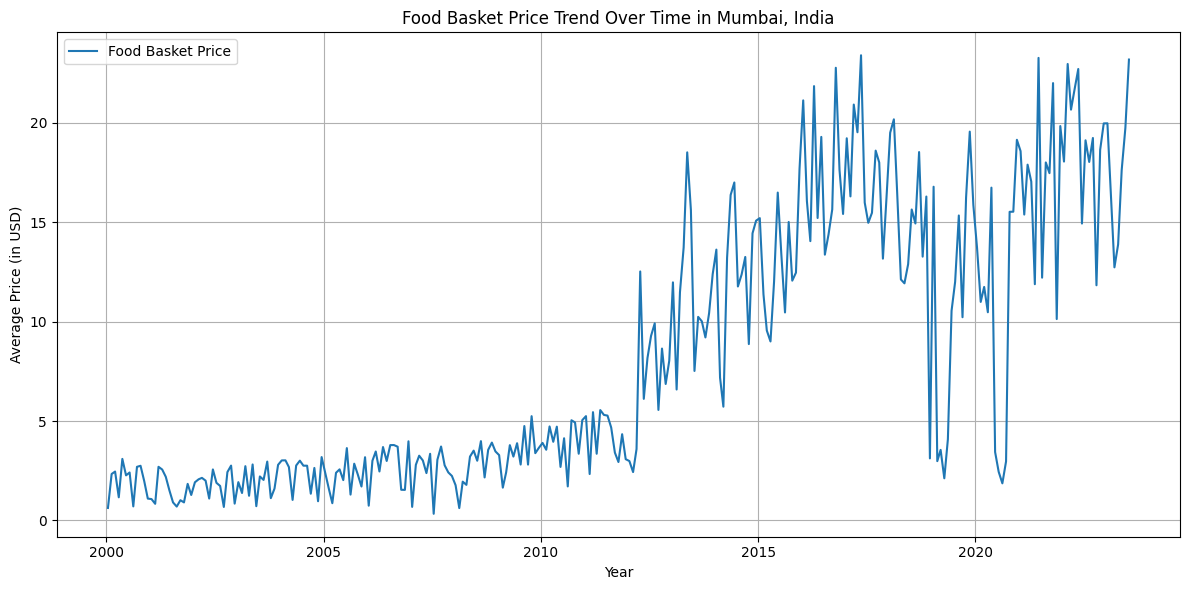

In [1629]:
# plotting the food basket price over time
date = df_basket["date"]
weighted_price = df_basket["usdprice"]

plt.figure(figsize=(12, 6))

plt.plot(date, weighted_price, label='Food Basket Price')

plt.title('Food Basket Price Trend Over Time in Mumbai, India')
plt.xlabel('Year')
plt.ylabel('Average Price (in USD)')

plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # show a year tick every 5 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend() 
plt.tight_layout()  

plt.show()

# Holt's Linear Trend Method Implementation

## Using statsmodels

In [1635]:
df_basket

,date,usdprice
0,2000-01-15,0.630179
1,2000-02-15,2.339825
2,2000-03-15,2.461502
3,2000-04-15,1.165981
4,2000-05-15,3.098480
...,...,...
278,2023-03-15,12.736700
279,2023-04-15,13.889500
280,2023-05-15,17.633900
281,2023-06-15,19.753600


In [1636]:
usd_price = np.array(df_basket['usdprice'])
dates = np.array(df_basket['date'])

In [1637]:
# apply Holt's trend method
model = Holt(weighted_price).fit()

# Forecast the next 60 periods
predictions = model.forecast(steps=60)

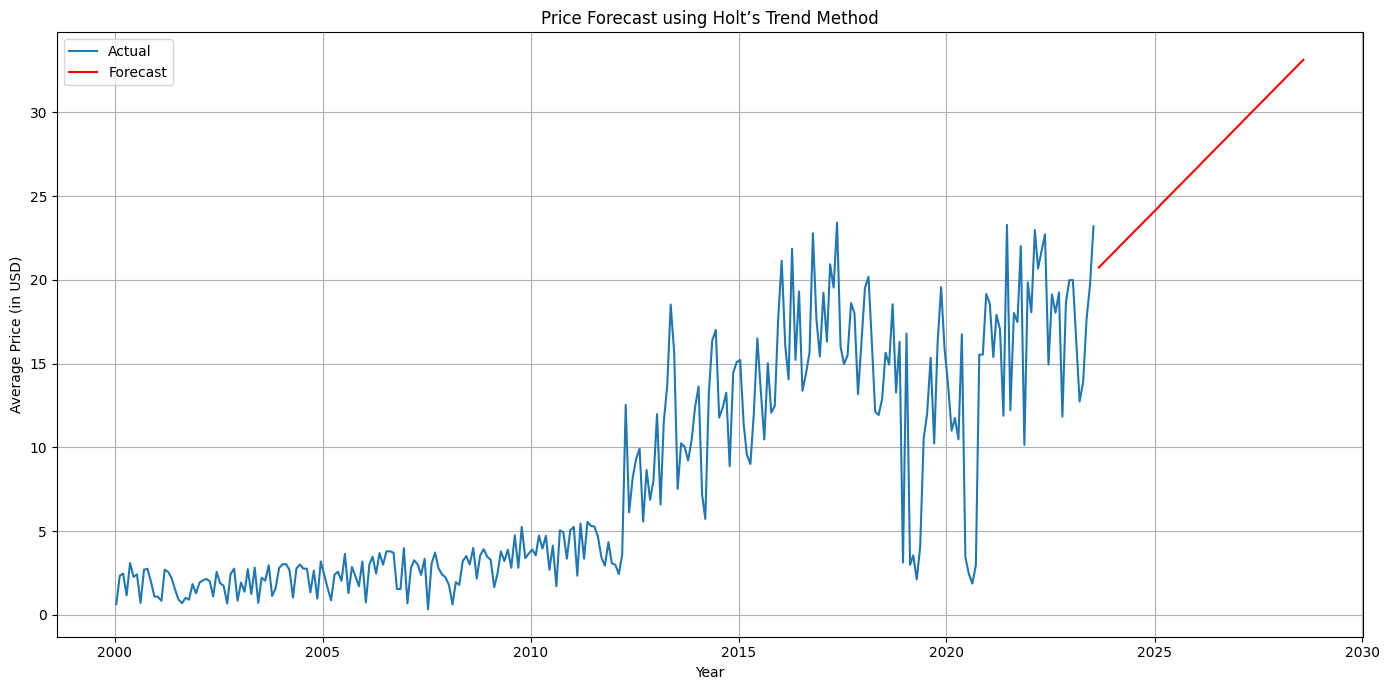

In [1638]:
# create a date range for the predictions (x-axis)
last_date = dates[-1]
prediction_dates = pd.date_range(start=last_date, periods=61, freq='M')[1:] 

# plot the results
plt.figure(figsize=(14, 7))
plt.plot(dates,usd_price, label='Actual')
plt.plot(prediction_dates, predictions, label='Forecast', color='red')

plt.title('Price Forecast using Holt’s Trend Method')
plt.xlabel('Year')
plt.ylabel('Average Price (in USD)')

plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # show a year tick every 5 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend() 
plt.tight_layout()  

plt.show()

## From Scratch

In [1639]:
# Holt's Linear Trend Method Implementation
def holt_linear_trend(series, dates, alpha, beta, n_forecast):
    n = len(series)
    level = np.zeros(n)
    trend = np.zeros(n)
    forecast = np.zeros(n_forecast)
    
    # initializing level and trend
    level[0] = series[0]
    trend[0] = series[1] - series[0]
    
    # Holt's Linear Trend equations
    for t in range(1, n):
        level[t] = alpha * series[t] + (1 - alpha) * (level[t-1] + trend[t-1])
        trend[t] = beta * (level[t] - level[t-1]) + (1 - beta) * trend[t-1]
    
    # forecasting future values
    last_level = level[-1]
    last_trend = trend[-1]
    for t in range(n_forecast):
        forecast[t] = last_level + (t+1) * last_trend

    # setting dates for forecasted values
    last_date = dates[-1]
    forecast_dates = pd.date_range(start=last_date, periods=n_forecast+1, freq='M')[1:] 
    
    return forecast, forecast_dates

In [1640]:
alpha = 0.3  # level smoothing coefficient
beta = 0.1  # trend smoothing coefficient
n_forecast = 60  # number of periods to forecast

usd_price = np.array(df_basket['usdprice'])
dates = np.array(df_basket['date'])

forecast, forecast_dates = holt_linear_trend(usd_price, dates, alpha, beta, n_forecast)

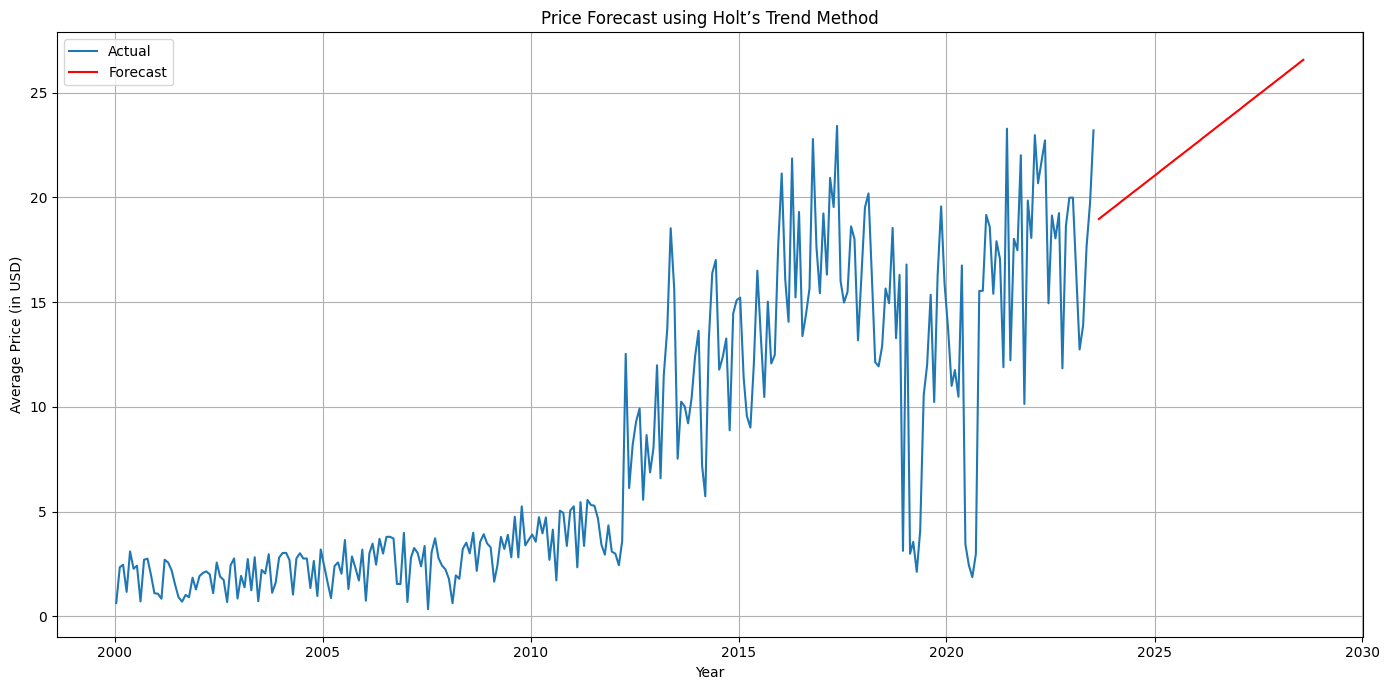

In [1641]:
# plot the results
plt.figure(figsize=(14, 7))
plt.plot(dates, usd_price, label='Actual')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')

plt.title('Price Forecast using Holt’s Trend Method')
plt.xlabel('Year')
plt.ylabel('Average Price (in USD)')

plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # show a year tick every 5 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend() 
plt.tight_layout()  

plt.show()